In [ ]:
# Install required packages
!pip install datasets transformers tokenizers sacrebleu torch
!pip install regex grapheme tqdm

import os
import re
import time
import pickle
import regex
import grapheme
import torch
import json
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import (
    PreTrainedTokenizerFast,
    EncoderDecoderModel,
    BertConfig,
    EncoderDecoderConfig,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import sacrebleu

In [ ]:
class GPETokenizer:
    """GPE Tokenizer with HuggingFace-compatible interface"""

    def __init__(self, vocab_size=16000, dummy_prefix="▁"):
        self.vocab_size = vocab_size
        self.dummy_prefix = dummy_prefix

        self.vocab = {}       # id -> string
        self.vocab_re = {}    # string -> id
        self.merges = {}      # (id1, id2) -> new_id
        self.trained = False


        # Regex pattern for text chunking
        #self.whitespace_pattern = r"\w+|[^\w\s]"
        self.whitespace_pattern = r" ?\w+| ?[^\w\s]+"

        # HF compatibility attributes
        self.pad_token = "[PAD]"
        self.unk_token = "[UNK]"
        self.bos_token = "[BOS]"
        self.eos_token = "[EOS]"



    def train(self, texts):
        """Train tokenizer on list of text strings."""
        print(f"Training GPE tokenizer on {len(texts)} texts...")

        # Initialize vocab with special tokens
        self.vocab = {v: k for k, v in self.special_tokens.items()}
        self.vocab_re = self.special_tokens.copy()


        texts = [regex.sub(r"\s+", " ", t.strip()) for t in texts]

        # Collect initial graphemes
        initial_graphemes = set()
        for text in tqdm(texts[:10000], desc="Collecting graphemes"):  # Limit for speed
            text_chunks = regex.findall(self.whitespace_pattern, text)
            text_chunks = [t.replace(" ", "▁") for t in text_chunks if t.strip()]

            for chunk in text_chunks:
                graphemes_list = list(grapheme.graphemes(chunk))
                initial_graphemes.update(graphemes_list)

        # Add graphemes to vocab
        current_id = len(self.vocab)
        for g in sorted(initial_graphemes):
            if g not in self.vocab_re:
                self.vocab[current_id] = g
                self.vocab_re[g] = current_id
                current_id += 1

        print(f"Initial vocab size: {len(self.vocab)}")

        # Calculate number of merges needed
        num_merges = min(self.vocab_size - len(self.vocab), 5000)  # Cap merges for speed

        # Convert texts to IDs for merging
        ids_list = self._convert_to_ids_train(texts[:10000])  # Limit for speed

        # Perform merges
        for i in tqdm(range(num_merges), desc="Merging"):
            stats = {}
            for chunk_ids in ids_list:
                self._get_stats(chunk_ids, stats)

            if not stats:
                break

            pair = max(stats, key=stats.get)
            idx = len(self.vocab)

            # Update IDs with merge
            ids_list = [self._merge(chunk_ids, pair, idx) for chunk_ids in ids_list]

            # Record merge
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]

            if i % 100 == 0:
                print(f"Merge {i}: {self.vocab[pair[0]]} + {self.vocab[pair[1]]} -> {self.vocab[idx]}")

        # Update reverse vocab
        self.vocab_re = {v: k for k, v in self.vocab.items()}

        print(f"Training complete. Final vocab size: {len(self.vocab)}")
        self.trained = True

    def encode(self, text, add_special_tokens=True, max_length=None, truncation=False, padding=False):
        """Encode text to token IDs."""
        if not self.trained:
            raise ValueError("Tokenizer not trained")

        # Handle batch input
        if isinstance(text, list):
            return [self.encode(t, add_special_tokens, max_length, truncation, padding) for t in text]

        # Process text
        text_chunks = regex.findall(self.whitespace_pattern, text)
        text_chunks = [t.replace(" ", "▁") for t in text_chunks if t.strip()]

        ids = []
        for chunk in text_chunks:
            graphemes_list = list(grapheme.graphemes(chunk))
            for g in graphemes_list:
                if g in self.vocab_re:
                    ids.append(self.vocab_re[g])
                else:
                    ids.append(self.unk_token_id)

        # Apply merges
        ids = self._apply_merges(ids)

        # Add special tokens
        if add_special_tokens:
            ids = [self.bos_token_id] + ids + [self.eos_token_id]

        # Truncation
        if truncation and max_length and len(ids) > max_length:
            ids = ids[:max_length]

        # Padding
        if padding and max_length:
            if len(ids) < max_length:
                ids = ids + [self.pad_token_id] * (max_length - len(ids))

        return ids

    def decode(self, ids, skip_special_tokens=True):
        """Decode token IDs to text."""
        if isinstance(ids[0], list):
            return [self.decode(i, skip_special_tokens) for i in ids]

        tokens = []
        for i in ids:
            if skip_special_tokens and i in [0, 1, 2, 3]:
                continue
            if i in self.vocab:
                tokens.append(self.vocab[i])

        text = "".join(tokens).replace("▁", " ")
        return text.strip()

    def batch_decode(self, ids_batch, skip_special_tokens=True):
        """Decode batch of token IDs."""
        return [self.decode(ids, skip_special_tokens) for ids in ids_batch]

    def __len__(self):
        """Return vocabulary size."""
        return len(self.vocab)

    def tokenize(self, text):
        """Tokenize text into subword strings."""
        ids = self.encode(text, add_special_tokens=False)
        return [self.vocab.get(i, self.unk_token) for i in ids]

    def __call__(self, text, **kwargs):
        """HuggingFace-compatible call interface."""
        if isinstance(text, str):
            text = [text]

        max_length = kwargs.get('max_length', None)
        padding = kwargs.get('padding', False)
        truncation = kwargs.get('truncation', False)
        return_tensors = kwargs.get('return_tensors', None)

        if padding == "max_length":
            padding = True

        encoded = []
        attention_masks = []

        for t in text:
            ids = self.encode(t, max_length=max_length, truncation=truncation, padding=padding)
            encoded.append(ids)

            # Create attention mask
            mask = [1 if i != self.pad_token_id else 0 for i in ids]
            attention_masks.append(mask)

        result = {
            'input_ids': encoded,
            'attention_mask': attention_masks
        }

        if return_tensors == "pt":
            result['input_ids'] = torch.tensor(result['input_ids'])
            result['attention_mask'] = torch.tensor(result['attention_mask'])

        return result

    def save(self, path):
        """Save tokenizer to disk."""
        os.makedirs(path, exist_ok=True)

        save_dict = {
            'vocab': self.vocab,
            'merges': self.merges,
            'special_tokens': self.special_tokens,
            'vocab_size': self.vocab_size
        }

        with open(os.path.join(path, 'gpe_tokenizer.pkl'), 'wb') as f:
            pickle.dump(save_dict, f)

        # Save config for HF compatibility
        config = {
            'tokenizer_class': 'GPETokenizerHF',
            'vocab_size': len(self.vocab),
            'pad_token': self.pad_token,
            'unk_token': self.unk_token,
            'bos_token': self.bos_token,
            'eos_token': self.eos_token
        }

        with open(os.path.join(path, 'tokenizer_config.json'), 'w') as f:
            json.dump(config, f)

    def load(self, path):
        """Load tokenizer from disk."""
        with open(os.path.join(path, 'gpe_tokenizer.pkl'), 'rb') as f:
            save_dict = pickle.load(f)

        self.vocab = save_dict['vocab']
        self.merges = save_dict['merges']
        self.special_tokens = save_dict['special_tokens']
        self.vocab_size = save_dict['vocab_size']

        self.vocab_re = {v: k for k, v in self.vocab.items()}
        self.trained = True

    # Helper methods
    def _get_stats(self, ids, counts=None):
        counts = {} if counts is None else counts
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def _merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids)-1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def _apply_merges(self, ids):
        """Apply learned merges to a sequence of IDs."""
        made_merge = True
        while made_merge:
            made_merge = False
            new_ids = []
            i = 0
            while i < len(ids):
                if i < len(ids) - 1 and (ids[i], ids[i+1]) in self.merges:
                    new_ids.append(self.merges[(ids[i], ids[i+1])])
                    i += 2
                    made_merge = True
                else:
                    new_ids.append(ids[i])
                    i += 1
            ids = new_ids
        return ids

    def _convert_to_ids_train(self, texts):
        """Convert texts to IDs for training."""
        ids_list = []
        for text in texts:
            text_chunks = regex.findall(self.whitespace_pattern, text)
            text_chunks = [t.replace(" ", "▁") for t in text_chunks if t.strip()]

            for chunk in text_chunks:
                graphemes_list = list(grapheme.graphemes(chunk))
                chunk_ids = []
                for g in graphemes_list:
                    if g in self.vocab_re:
                        chunk_ids.append(self.vocab_re[g])
                if chunk_ids:
                    ids_list.append(chunk_ids)

        return ids_list

    def pad(self, encoded_inputs, padding=True, max_length=None, return_tensors=None, **kwargs):
      """
      HuggingFace-compatible pad method.
      Can handle a single dict or a list of dicts with 'input_ids' and 'attention_mask'.
      """
      # Case 1: already a batch dict
      if isinstance(encoded_inputs, dict) and "input_ids" in encoded_inputs:
          input_ids = encoded_inputs["input_ids"]
          attention_mask = encoded_inputs.get("attention_mask", None)

      # Case 2: list of dicts (from DataCollator)
      elif isinstance(encoded_inputs, (list, tuple)):
          input_ids = [e["input_ids"] for e in encoded_inputs]
          attention_mask = [e.get("attention_mask") for e in encoded_inputs]
          if all(am is None for am in attention_mask):
              attention_mask = None
      else:
          raise TypeError("Unsupported input format for pad()")

      # Convert tensors to lists if needed
      if isinstance(input_ids, torch.Tensor):
          input_ids = input_ids.tolist()
      if attention_mask is not None and isinstance(attention_mask, torch.Tensor):
          attention_mask = attention_mask.tolist()

      max_len = max_length or max(len(seq) for seq in input_ids)

      padded_ids, padded_mask = [], []
      for i, seq in enumerate(input_ids):
          # Ensure list, not tensor
          if isinstance(seq, torch.Tensor):
              seq = seq.tolist()

          pad_len = max_len - len(seq)
          padded_seq = seq + [self.pad_token_id] * pad_len
          padded_ids.append(padded_seq)

          if attention_mask is not None and attention_mask[i] is not None:
              mask_seq = attention_mask[i]
              if isinstance(mask_seq, torch.Tensor):
                  mask_seq = mask_seq.tolist()
              mask_seq = mask_seq + [0] * pad_len
          else:
              mask_seq = [1] * len(seq) + [0] * pad_len
          padded_mask.append(mask_seq)

      result = {
          "input_ids": torch.tensor(padded_ids) if return_tensors == "pt" else padded_ids,
          "attention_mask": torch.tensor(padded_mask) if return_tensors == "pt" else padded_mask,
      }
      return result

README.md: 0.00B [00:00, ?B/s]

en-si/test-00000-of-00001.parquet:   0%|          | 0.00/155k [00:00<?, ?B/s]

en-si/train-00000-of-00001.parquet:   0%|          | 0.00/65.8M [00:00<?, ?B/s]

en-si/validation-00000-of-00001.parquet:   0%|          | 0.00/153k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/979109 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 979109
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
Sample translation: {'en': 'Boone!', 'si': 'බුන්!'}
Training samples: 979109
Validation samples: 2000


Training English GPE tokenizer...
Training GPE tokenizer on 979109 texts...


Initial vocab size: 121


Merging:   0%|          | 0/5000 [00:00<?, ?it/s]

Merge 0: ▁ + t -> ▁t
Merge 100: i + r -> ir
Merge 200: e + m -> em
Merge 300: omet + hing -> omething
Merge 400: e + w -> ew
Merge 500: ▁ne + w -> ▁new
Merge 600: hic + h -> hich
Merge 700: ▁to + day -> ▁today
Merge 800: ▁kill + ed -> ▁killed
Merge 900: h + ind -> hind
Merge 1000: ▁s + ame -> ▁same
Merge 1100: ▁other + s -> ▁others
Merge 1200: ▁you + ng -> ▁young
Merge 1300: out + h -> outh
Merge 1400: ▁comm + and -> ▁command
Merge 1500: ▁l + ine -> ▁line
Merge 1600: ▁ro + ad -> ▁road
Merge 1700: ▁chang + es -> ▁changes
Merge 1800: ▁en + g -> ▁eng
Merge 1900: ick + s -> icks
Merge 2000: ▁he + y -> ▁hey
Merge 2100: atter + y -> attery
Merge 2200: il + i -> ili
Merge 2300: ▁ + 8 -> ▁8
Merge 2400: B + ack -> Back
Merge 2500: c + ons -> cons
Merge 2600: ▁m + is -> ▁mis
Merge 2700: ▁S + p -> ▁Sp
Merge 2800: ▁Y + ork -> ▁York
Merge 2900: y + er -> yer
Merge 3000: ▁po + ison -> ▁poison
Merge 3100: ▁tong + ue -> ▁tongue
Merge 3200: en + a -> ena
Merge 3300: c + ut -> cut
Merge 3400: Gu + y -> 

Initial vocab size: 714


Merging:   0%|          | 0/5000 [00:00<?, ?it/s]

Merge 0: න් + න -> න්න
Merge 100: ▁හි + ත -> ▁හිත
Merge 200: ▁ + " -> ▁"
Merge 300: ත + ක -> තක
Merge 400: ද් + ධ -> ද්ධ
Merge 500: ▁ඇ + හු -> ▁ඇහු
Merge 600: ▁විදිහ + ට -> ▁විදිහට
Merge 700: නු + ව -> නුව
Merge 800: ▁වෙ + ඩි -> ▁වෙඩි
Merge 900: ▁කා + ර -> ▁කාර
Merge 1000: ▁එක + ම -> ▁එකම
Merge 1100: ත්ත + ර -> ත්තර
Merge 1200: ▁ + o -> ▁o
Merge 1300: ▁අ + නු -> ▁අනු
Merge 1400: ▁තත් + ප -> ▁තත්ප
Merge 1500: ▁ඔහු + ගෙ -> ▁ඔහුගෙ
Merge 1600: ▁ස් + ව -> ▁ස්ව
Merge 1700: එයා + ගෙ -> එයාගෙ
Merge 1800: ▁මර + න්න -> ▁මරන්න
Merge 1900: ▁මේ + වා -> ▁මේවා
Merge 2000: ▁හොයා + ගත්තේ -> ▁හොයාගත්තේ
Merge 2100: ▁අමාරු + යි -> ▁අමාරුයි
Merge 2200: ▁ඔ + තන -> ▁ඔතන
Merge 2300: ▁ + ටැ -> ▁ටැ
Merge 2400: ▁ඇද + ලා -> ▁ඇදලා
Merge 2500: a + b -> ab
Merge 2600: ව් + වේ -> ව්වේ
Merge 2700: ▁ලබා + ගන්න -> ▁ලබාගන්න
Merge 2800: ▁දු + ෂ් -> ▁දුෂ්
Merge 2900: ▁කණ්ඩා + යම -> ▁කණ්ඩායම
Merge 3000: ▁පහ + ළ -> ▁පහළ
Merge 3100: ▁ආරක්ෂි + තයි -> ▁ආරක්ෂිතයි
Merge 3200: බ + හු -> බහු
Merge 3300: සි + යා -> සියා
Merge 3400: 


Sample 1
EN: Sivagami, why use sword for killing a bird, I heard that Baahubali is near that country
EN tokens (first 10): ['S', 'iv', 'ag', 'ami', ',', '▁why', '▁use', '▁s', 'wo', 'r', 'd', '▁for', '▁k', 'il', 'ling', '▁a', '▁bir', 'd', ',', '▁I', '▁h', 'ea', 'r', 'd', '▁that', '▁B', 'aa', 'h', 'ub', 'ali', '▁i', 's', '▁n', 'ea', 'r', '▁that', '▁cou', 'nt', 'ry']
EN IDs (first 10): [2, 50, 910, 463, 4260, 15, 637, 799, 129, 511, 79, 65, 214, 186, 287, 3079, 124, 1965, 65, 15, 154, 171, 250, 79, 65, 185, 313, 971, 69, 1026, 2249, 1631, 80, 155, 250, 79, 185, 1245, 396, 268, 3]
SI: - ශිව ගාමි. - කූඹියෙක්ව මරන්න මහ අවි ඇයි ? - බාහුබලි ඒ රාජ්‍යය අහල පහල කියා අහන්න ලැබුනා.
SI tokens (first 10): ['-', '▁ශි', 'ව', '▁ගා', 'මි', '.', '▁-', '▁කූ', 'ඹි', 'යෙක්', 'ව', '▁ම', 'රන්', 'න', '▁මහ', '▁අ', 'වි', '▁ඇයි', '▁?', '▁-', '▁බා', 'හු', 'බ', 'ලි', '▁ඒ', '▁රා', 'ජ්\u200d', 'යය', '▁අ', 'හල', '▁ප', 'හල', '▁කියා', '▁අ', 'හන්', 'න', '▁ලැබුනා', '.']
SI IDs (first 10): [2, 16, 2497, 575, 1060, 479, 17,

Encoding training dataset...


Map:   0%|          | 0/979109 [00:00<?, ? examples/s]

Encoding validation dataset...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Encoded train samples: 979109
Encoded val samples: 2000


{'input_ids': torch.Size([1, 64]), 'attention_mask': torch.Size([1, 64]), 'labels': torch.Size([1, 64])}
torch.Size([64])
torch.Size([64])
tensor([   2,   33,  202, 2048,    4,    3,    0,    0,    0,    0])
tensor([   2, 3938,    4,    3,    0,    0,    0,    0,    0,    0])


EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5121, 256, padding_idx=0)
      (position_embeddings): Embedding(128, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, eleme

/tmp/ipython-input-4223306290.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Bleu
1000,5.497100,5.528796,0.083424
2000,5.097300,5.193930,0.169556
3000,4.816500,4.954597,0.713350
4000,4.657800,4.785016,0.845435
5000,4.518800,4.663736,1.242438
6000,4.405300,4.563923,1.426448
7000,4.327600,4.478820,1.507599
8000,4.267700,4.401356,1.672789
9000,4.171200,4.335440,2.073626
10000,4.110300,4.279902,2.348938


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 

{'eval_loss': 3.486330509185791, 'eval_bleu': 4.447338125403548, 'eval_runtime': 20.436, 'eval_samples_per_second': 97.867, 'eval_steps_per_second': 6.117, 'epoch': 1.0}


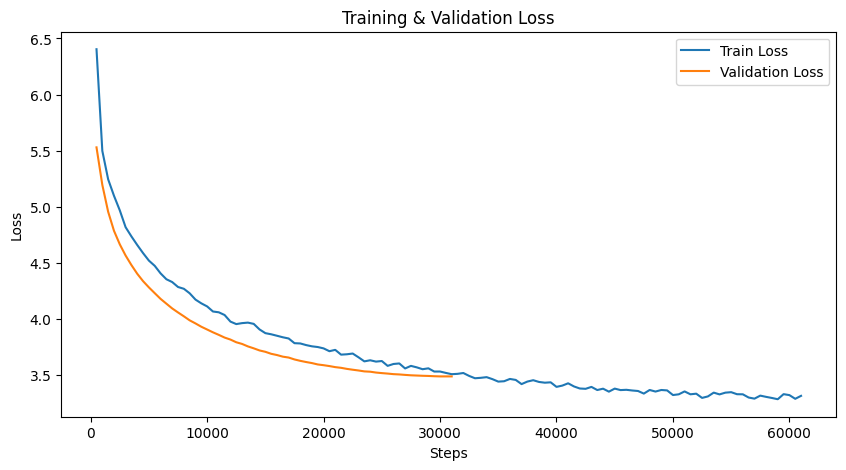

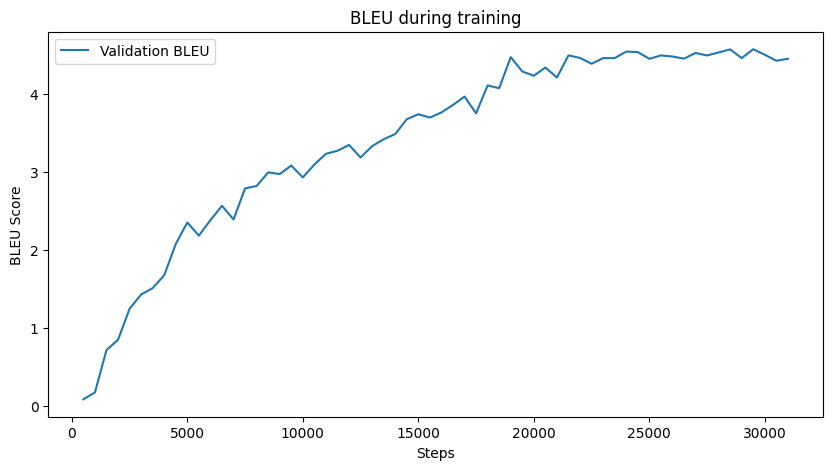

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

EN: Sivagami, why use sword for killing a bird, I heard that Baahubali is near that country
REF: - ශිව ගාමි. - කූඹියෙක්ව මරන්න මහ අවි ඇයි ? - බාහුබලි ඒ රාජ්‍යය අහල පහල කියා අහන්න ලැබුනා.
PRED: සතුරා, ඇයි මට කියන්නෙ, ඒ වගේම මම ඒ වගේම මරන්න ඕන, ඒ වගේම මට ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම ඒ වගේම මට ඒ වගේම මට කියන්න එක ගැන කියන්න පු
--------------------------------------------------
EN: I do believe we've known each other since forever, though.
REF: මං විශ්වාස කරන්නෙ අපි එකිනෙකා හඳුනාගත්ත දා ඉඳං සදහටම එක්ට ඉන්න එක විතරයි.
PRED: මම හිතන්නේ අපි හැමෝම දන්නවා අපි එයාව මරලා තියෙන්නේ කියලා.
--------------------------------------------------
EN: "First instinct, usually the right one."
REF: "පළමු දේ තමයි නිවැරදි වෙන්නෙ."
PRED: "ඒ වගේම ඒක තමයි, ඒ වගේම, ඒ වගේම, ඒ වගේම.
--------------------------------------------------
EN: I just ran a second check on the ramps. They look good.
REF: මම දැන් දෙවනි පාරටත් අට අර කළබලේ මැද්දට ගියා.එයාලා හොදට පේනවා.
PRED